In [5]:
import io
import json
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
import spacy
from tqdm.notebook import trange, tqdm

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:

def load_vectors(fname, total_to_load=10000):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    total_loaded = 0
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
        total_loaded += 1
        if total_loaded >= total_to_load:
            break
    return data

In [8]:
DATA_PATH = "../data/"

In [9]:
# wiki_100k = pd.read_csv(DATA_PATH + "/wiki-100k.txt", names=["word"], index=)

# wiki_100k = []
# with open(DATA_PATH + "/wiki-100k.txt", "r") as f:
#     for line in f:
#         if line[:2] != "#!":
#             wiki_100k.append(line.strip())

# len(wiki_100k)

In [10]:
red_clues_1 = ['pit', 'newton', 'elephant', 'sub', 'street', 'model', 'lemon', 'lock']
blue_clues_1 = ['judge', 'paddle', 'volcano', 'bed', 'break', 'driver', 'ram', 'hotel']
gray_clues_1 = ['snow', 'tattoo', 'guitar', 'paint', 'trick', 'walrus', 'hook']
black_clues_1 = ["squirrel"]

In [11]:
red_clues = ['fog', 'tornado', 'poison', 'purse', 'night', 'brush', 'aztec', 'blade']
blue_clues = ['crab', 'balloon', 'diamond', 'file', 'state', 'ruler', 'sound', 'dollar', 'drum']
gray_clues = ['shower', 'tea', 'university', 'bomb', 'leather', 'cover', 'tattoo']
black_clues = ['mouse']

In [12]:
all_clues = red_clues + blue_clues + gray_clues + black_clues + red_clues_1 + blue_clues_1 + gray_clues_1 + black_clues_1

In [13]:
clues_to_lemmas = {}
for clue in all_clues:
    doc = nlp(clue)
    for token in doc:
        clues_to_lemmas[clue] = token.lemma_
        
for clue_set in [blue_clues, red_clues, gray_clues, black_clues]:
    for i in range(len(clue_set)):
        clue_set[i] = clues_to_lemmas[clue_set[i]]

In [14]:
import io

def load_vectors_pd(fname, total_to_load=10000):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    index = []
    total_loaded = 0
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
        total_loaded += 1
        if total_loaded >= total_to_load:
            break
    return pd.DataFrame(data)

In [15]:
# TODO: increase to 200k
# vectors = load_vectors_pd(DATA_PATH + "wiki-news-300d-1M.vec", 200000)
# news did not really match the 
vectors = load_vectors_pd(DATA_PATH + "crawl-300d-2M.vec", 200000)

In [16]:
# vectors = load_vectors_pd(DATA_PATH + "crawl-300d-2M.vec", 110000)

In [17]:
t_vectors = vectors.transpose()

In [18]:
vector_word_to_lemma_path = DATA_PATH + "/vector_word_to_lemma_v2.json"
with open(vector_word_to_lemma_path, "r") as f:
    vector_word_to_lemma = json.load(f)
# vector_word_to_lemma = dict()

for i in trange(vectors.shape[1]):
    word = vectors.columns[i]
    if word not in vector_word_to_lemma:
        doc = nlp(word)
        for token in doc:
            vector_word_to_lemma[word] = token.lemma_
            # there is punctuation that must be removed signs and such
            break

with open(vector_word_to_lemma_path, "w") as f:
    json.dump(vector_word_to_lemma, f)

  0%|          | 0/200000 [00:00<?, ?it/s]

In [19]:
len(vector_word_to_lemma.keys())

200000

In [20]:
len(set(vector_word_to_lemma.values()))

124348

In [21]:
# vector_word_to_lemma_path = DATA_PATH + "/vector_word_to_lemma.json"
# with open(vector_word_to_lemma_path, "r") as f:
#     vector_word_to_lemma = json.load(f)

# for i in trange(vectors.shape[1]):
#     word = vectors.columns[i]
#     if word not in vector_word_to_lemma:
#         doc = nlp(word)
#         for token in doc:
#             vector_word_to_lemma[word] = token.lemma_
#             break

# with open(DATA_PATH + "/vector_word_to_lemma.json", "w") as f:
#     json.dump(vector_word_to_lemma, f)

In [22]:
# import nltk

# from nltk.stem.porter import *

In [23]:
t_vectors["lemma"] = [vector_word_to_lemma[word] for word in t_vectors.index]

In [24]:
for clue in all_clues:
    assert(clue in t_vectors["lemma"])

In [25]:
red_distances = pd.DataFrame(euclidean_distances(vectors[red_clues].transpose(), vectors.transpose()),
                             index=red_clues, columns=vectors.columns)
blue_distances = pd.DataFrame(euclidean_distances(vectors[blue_clues].transpose(), vectors.transpose()), index=blue_clues, columns=vectors.columns)
gray_distances = pd.DataFrame(euclidean_distances(vectors[gray_clues].transpose(), vectors.transpose()), index=gray_clues, columns=vectors.columns)
black_distances = pd.DataFrame(euclidean_distances(vectors[black_clues].transpose(), vectors.transpose()), index=black_clues, columns=vectors.columns)

In [26]:
all_eucl_distances = pd.DataFrame(euclidean_distances(vectors[all_clues].transpose(), vectors.transpose()), index=all_clues, columns=vectors.columns)
all_cos_distances = pd.DataFrame(cosine_distances(vectors[all_clues].transpose(), vectors.transpose()), index=all_clues, columns=vectors.columns)

<AxesSubplot:ylabel='Frequency'>

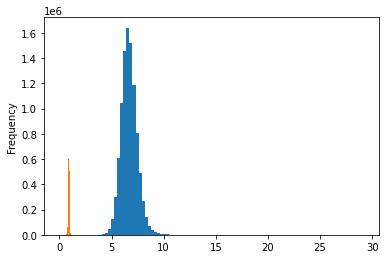

In [27]:
pd.Series(all_eucl_distances.values.flatten()).plot(kind="hist", bins=100)
pd.Series(all_cos_distances.values.flatten()).plot(kind="hist", bins=100)

In [28]:
# need to calibrate our activation function

In [29]:
eucl_stacked_distances = all_eucl_distances.stack()
cos_stacked_distances = all_cos_distances.stack()

In [30]:
# looking at Euclidean distances between words

viz_similarities = list()
prev_value = 0
for cur_value in np.linspace(3, 6, 20):
    distances = eucl_stacked_distances[np.logical_and(eucl_stacked_distances > prev_value, eucl_stacked_distances < cur_value).values]
    diff_lemma_distances = distances[[idx[0] != vector_word_to_lemma[idx[1]] for idx in distances.index]]
    if diff_lemma_distances.shape[0] >= 1:
        viz_distances = diff_lemma_distances.sample(1)
        viz_similarities.append((prev_value, cur_value, viz_distances.index[0][0], viz_distances.index[0][1], viz_distances.values[0]))
    prev_value = cur_value

df_viz_similarities = pd.DataFrame(viz_similarities)

df_viz_similarities.loc[:, 1:3]

,1,2,3
0,3.000000,model,Model
1,3.157895,purse,handbag
2,3.315789,night,nite
3,3.473684,night,tonight
4,3.631579,night,the
5,3.789474,state,though
6,3.947368,break,set
7,4.105263,model,being
8,4.263158,state,leave
9,4.421053,night,play


In [31]:
def compare_clue_to_word(clue, word):
    lower_word = word.lower()
    lower_lemma = vector_word_to_lemma[word].lower()
    return clue not in lower_lemma and lower_lemma not in clue and clue not in lower_word and lower_word not in clue

In [32]:
compare_clue_to_word("model", "Modes")

False

In [33]:
def transform_cos_distance(cos_distance, a, b):
    return np.exp(a - b * cos_distance) / (1 + np.exp(a - b * cos_distance))

In [34]:
# looking at cosine distances between words

viz_similarities = list()
prev_value = 0
for cur_value in np.linspace(0, 1, 200):
    distances = cos_stacked_distances[np.logical_and(cos_stacked_distances > prev_value, cos_stacked_distances < cur_value).values]
    diff_lemma_distances = distances[[compare_clue_to_word(idx[0], idx[1]) for idx in distances.index]]
    if diff_lemma_distances.shape[0] >= 1:
        viz_distances = diff_lemma_distances.sample(1)
        viz_similarities.append((prev_value, cur_value, viz_distances.index[0][0], viz_distances.index[0][1], viz_distances.values[0]))
    prev_value = cur_value

In [35]:
pd_viz_sim = pd.DataFrame(viz_similarities, columns=["begin_bucket", "end_bucket", "clue", "word", "cos_dist"])
pd_viz_sim["prob"] = transform_cos_distance(pd_viz_sim["cos_dist"], a=14, b=22)

for _, row in pd_viz_sim[["cos_dist", "prob", "clue", "word"]].iterrows():
    print(row.values)

[0.1461625378504332 0.9999792806992102 'tattoo' 'tatoo']
[0.1780699904801224 0.9999581953096334 'balloon' 'baloon']
[0.20624862709994285 0.9999222963177029 'elephant' 'pachyderm']
[0.2144460019122465 0.9999069413874515 'purse' 'handbag']
[0.2302891818042785 0.999868140008533 'volcano' 'volcanic']
[0.24113242205091012 0.9998326217115887 'crab' 'lobster']
[0.24563978660286878 0.9998151765541395 'leather' 'suede']
[0.24963424483849606 0.9997982030231127 'crab' 'crustacean']
[0.26325428722620203 0.9997277195613982 'tornado' 'twister']
[0.27279839510303616 0.9996641249154293 'balloon' 'ballons']
[0.27691725645343657 0.9996322797672016 'tattoo' 'tatoos']
[0.28530262256255035 0.9995578160497227 'guitar' '12-string']
[0.2944385768104467 0.9994594330292066 'fog' 'mist']
[0.30057056242316105 0.9993814091003328 'volcano' 'lava']
[0.3044508220518931 0.9993263203262723 'bomb' 'detonate']
[0.3099264824636445 0.9992401408978213 'tea' 'coffee']
[0.3119403656288561 0.9992057454263074 'shower' 'bathroom

In [36]:
pd_viz_sim[["cos_dist", "clue", "word"]].iloc[list(range(0, 147, 5)), :]

,cos_dist,clue,word
0,0.146163,tattoo,tatoo
5,0.241132,crab,lobster
10,0.276917,tattoo,tatoos
15,0.309926,tea,coffee
20,0.334705,crab,crustaceans
25,0.356877,walrus,whale
30,0.382509,lemon,lime
35,0.408832,night,daytime
40,0.432457,mouse,rat
45,0.461752,purse,Wristlet


In [34]:
all_prob_from_cosine = transform_cos_distance(all_cos_distances, a=12, b=16)


In [35]:
words_to_keep = []
for word in all_prob_from_cosine.columns:
    keep_word = True
    for clue in all_prob_from_cosine.index:
        if compare_clue_to_word(clue, word) is False:
            keep_word = False
    if keep_word:
        words_to_keep.append(word)

In [36]:
def colors_from_clues(s):
    colors = []
    for idx in s.index:
        if idx in red_clues:
            colors.append('background-color: lightcoral')
        if idx in blue_clues:
            colors.append('background-color: cornflowerblue')
        if idx in gray_clues:
            colors.append('background-color: gray')
        if idx in black_clues:
            colors.append('background-color: dimgray')
    return colors

In [37]:
def utility_function(probs, red_clues, blue_clues, gray_clues, black_clues, team="red"):
    # We should actually simulate the process of drawing these clues
    # it's very bad to draw the assassin, so let's try to stay away from him at all costs
    black_util = all_prob_from_cosine.loc[black_clues, :].sum(axis=0) * -15
    # it's not really that bad to draw a gray tile, but it might stop you from finding the right tile
    opportunity_cost = -0.04
    gray_util = all_prob_from_cosine.loc[gray_clues, :].sum(axis=0) * opportunity_cost
    red_util = all_prob_from_cosine.loc[red_clues, :].sum(axis=0)
    blue_util = all_prob_from_cosine.loc[blue_clues, :].sum(axis=0)
    if team == "red":
        blue_util = -1 * blue_util + opportunity_cost
    if team == "blue":
        red_util = -1 * red_util + opportunity_cost
    if team != "red" and team != "blue":
        return Exception
    return black_util + gray_util + red_util + blue_util

In [38]:
import matplotlib.pyplot as plt

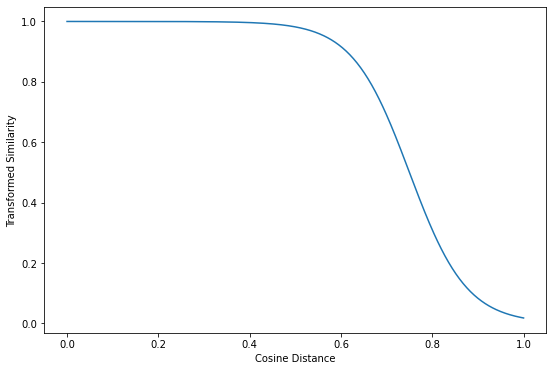

In [44]:
x = np.linspace(0, 1, 500)
y = transform_cos_distance(x, a=12, b=16)
pd.DataFrame({"x": x, "y": y}).plot(x="x", y="y", kind="line", legend=False)
plt.xlabel("Cosine Distance")
plt.ylabel("Transformed Similarity")
# plt.legend(False)
plt.gcf().set_size_inches(9, 6)

In [45]:
# 9, 14 was pretty good
all_prob_from_cosine = transform_cos_distance(all_cos_distances, a=12, b=16)
utility_by_word = utility_function(all_prob_from_cosine, red_clues, blue_clues, gray_clues, black_clues, team="blue")
# utility_by_word[words_to_keep].sort_values().tail(40)
candidate_words = utility_by_word[words_to_keep].sort_values().tail(40).index
candidate_probs = all_prob_from_cosine[candidate_words]
color_candidate_probs_df = candidate_probs.style.apply(colors_from_clues, axis=0)

In [46]:
color_candidate_probs_df

,sovereignty,deflating,investment,hegemon,eighths,FEDERAL,compressed,Trillion,republics,asset,provincial,national,nominal,Ceará,Angolan,inflated,records,corrupt,expansionary,Inflated,uncirculated,governor,emirate,tax-exempt,compression,kleptocracy,countrys,bankrupt,carats,investment-grade,issuer,governors,Wav,record,Federal,nation,government,federal,equalization,sovereign
fog,0.103867,0.222910,0.041392,0.105772,0.040870,0.038323,0.149487,0.025094,0.051483,0.080561,0.082197,0.080672,0.049490,0.027989,0.060014,0.097612,0.059988,0.041633,0.055552,0.088390,0.045793,0.099112,0.021724,0.037281,0.140733,0.084599,0.041884,0.115473,0.035775,0.018912,0.019161,0.021190,0.021649,0.044582,0.065000,0.055676,0.075363,0.110101,0.106398,0.081628
tornado,0.082799,0.080951,0.071967,0.035790,0.053209,0.077315,0.093303,0.053556,0.077117,0.096937,0.052767,0.061405,0.029538,0.135184,0.024872,0.063279,0.140940,0.030350,0.098877,0.056303,0.128223,0.151590,0.048314,0.095250,0.098242,0.070718,0.057992,0.056628,0.046202,0.081138,0.016207,0.059790,0.096031,0.121050,0.068947,0.116775,0.119102,0.135582,0.075156,0.098710
poison,0.120969,0.048623,0.042056,0.153245,0.066728,0.083214,0.054517,0.032415,0.146165,0.043151,0.064763,0.122246,0.059959,0.011844,0.022996,0.052070,0.020012,0.443138,0.056286,0.031291,0.013288,0.113060,0.025582,0.052480,0.018379,0.170207,0.039851,0.351543,0.022587,0.035959,0.015520,0.056502,0.024060,0.014713,0.084953,0.139658,0.250145,0.120757,0.042303,0.209480
purse,0.216696,0.091575,0.196664,0.196846,0.097824,0.071403,0.045624,0.114269,0.168179,0.074080,0.180475,0.129440,0.044312,0.035023,0.042729,0.140168,0.161528,0.175237,0.025095,0.086319,0.098625,0.161866,0.177985,0.131695,0.047683,0.348081,0.068776,0.224090,0.382475,0.114679,0.215429,0.073103,0.116446,0.143388,0.047408,0.123989,0.179633,0.122720,0.122366,0.342879
night,0.047885,0.100103,0.059122,0.063056,0.096750,0.052317,0.035325,0.083851,0.023473,0.060070,0.066369,0.059746,0.028876,0.065571,0.052050,0.047734,0.057904,0.034650,0.060262,0.037327,0.066913,0.078498,0.074524,0.017120,0.088540,0.045107,0.054201,0.061527,0.080409,0.023932,0.019576,0.058241,0.056535,0.150986,0.033872,0.196285,0.035245,0.055863,0.060050,0.026821
brush,0.057849,0.061939,0.047170,0.029985,0.080774,0.045394,0.195012,0.031974,0.026447,0.099870,0.077961,0.097379,0.121789,0.009769,0.048825,0.080402,0.043006,0.062835,0.022766,0.040814,0.061876,0.032872,0.035767,0.073704,0.109526,0.087500,0.045945,0.030672,0.073140,0.027828,0.013819,0.027209,0.100612,0.074795,0.071224,0.071765,0.089954,0.120771,0.108932,0.056925
aztec,0.233140,0.021264,0.050149,0.192026,0.235196,0.319761,0.134168,0.072041,0.207799,0.034207,0.079653,0.230719,0.040002,0.095602,0.300142,0.098612,0.086195,0.133320,0.176315,0.135823,0.128688,0.116435,0.126797,0.035382,0.323730,0.119140,0.390941,0.072462,0.064906,0.054900,0.147865,0.153691,0.284514,0.053840,0.102102,0.147437,0.127592,0.200127,0.060427,0.265140
blade,0.089001,0.024088,0.209410,0.229103,0.301281,0.047191,0.194609,0.081343,0.032271,0.148115,0.069951,0.017547,0.069699,0.015425,0.028705,0.031956,0.029170,0.062404,0.136138,0.014240,0.149993,0.068076,0.108178,0.024960,0.175325,0.060314,0.070178,0.049026,0.136002,0.156974,0.225458,0.050050,0.078791,0.023013,0.030906,0.087429,0.041568,0.071731,0.064825,0.078836
crab,0.144926,0.094119,0.034933,0.298248,0.274287,0.087844,0.301840,0.032282,0.051115,0.022755,0.219648,0.090966,0.064347,0.406532,0.474429,0.096593,0.045088,0.064603,0.043629,0.068277,0.103042,0.243793,0.056311,0.086370,0.206986,0.238997,0.119217,0.036263,0.124184,0.068471,0.070712,0.079981,0.150842,0.033375,0.066509,0.069503,0.092180,0.099502,0.130898,0.108257
balloon,0.115556,0.983608,0.022878,0.096968,0.123799,0.112371,0.477179,0.210740,0.328674,0.115655,0.035384,0.216724,0.236605,0.120713,0.060322,0.985077,0.042372,0.051878,0.169212,0.928229,0.040347,0.076551,0.123178,0.103825,0.421322,0.067236,0.061078,0.109302,0.131277,0.162930,0.203304,0.039890,0.062172,0.093971,0.102317,0.088315

In [ ]:
 Lock hotel snow paddle

In [ ]:
candidate_probs.index

In [ ]:
# 9, 14 was pretty good
all_prob_from_cosine = transform_cos_distance(all_cos_distances, a=12, b=16)
red_utility_by_word = utility_function(all_prob_from_cosine, red_clues, blue_clues, gray_clues, black_clues, team="red")
red_utility_by_word[words_to_keep].sort_values().tail(20)
candidate_words = red_utility_by_word[words_to_keep].sort_values().tail(20).index
candidate_probs = all_prob_from_cosine[candidate_words]
candidate_probs.style.apply(colors_from_clues, axis=0)


In [ ]:
all_prob_from_cosine["limes"].sort_values(ascending=False)

In [ ]:
total_hits = (all_prob_from_cosine > 0.4)[words_to_keep].sum(axis=0)

In [ ]:
total_hits.sort_values()

In [ ]:
all_prob_from_cosine["stick"]

In [ ]:
all_prob_from_cosine["keyless"]

In [ ]:
np.linspace(3, 10, 100)

In [ ]:
pd.Series(all_distances.values.flatten()).de

In [ ]:
red_distances.loc[:, "pit"]

In [ ]:
pd_distances = pd.DataFrame(distances, index=vectors.columns, columns=vectors.columns)